# <font color='black'>Deep Learning for Image Processing</font>

---
<figure>
<center>
<img src='https://drive.google.com/uc?id=1u-iZKwzco1L8a3gFFLMXbSOU_DsdNZqo' width="300" align="center" />
</center>
</figure>

> Year: **2022**

> Version: **1.1**

- You need to solve this exercises in groups of two or three --> A group of one person will be penalized with -3 points. 


- The first part of the exercise is guided.
- For the second part of the exercise that is not guided, the group(s) and their corresponding grade will be ranked as a function of the segmentation performance.

Please upload your work on Moodle. 

Good luck!

# Segmentation

In today's exercise you will experiment with image segmentation using deep learning.

## Set-up

Firstly you will import all the packages used through the notebook.  

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# import sys
# sys.path.append('/content/gdrive/MyDrive/0IPSA/Ma511/TP_22/TP3_Answers/') # The location of the .ipynb file. 
#This is necessary to import fr_utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

import matplotlib.pyplot as plt

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2
#import from local library

from u_net import u_net, u_net3
from keras_image2image import DeadLeavesWithSegmGenerator
from keras_custom_loss import jaccard2_loss, jaccard2_coef, dice2_loss, dice2_coef, jaccard1_loss, jaccard1_coef, dice1_loss, dice1_coef
from random_image_generator import AdditiveGaussianNoise
from random_image_generator import ROG_disks, ROG_rings, RandomPosGenUniform, RandomIntGenUniform
from ResUnet import UNet


/Users/leo/miniforge3/envs/ciri/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Generate the data

The following cell will help you create the images we will use in the practical. Firstly, you will need to define the objects that will help create the images.

In [3]:
img_rows, img_cols = 32, 32
img_channels = 1
gauss_n_std = 40
nb_obj_l = 1
nb_obj_h = 4
r1_disk_l = 2
r1_disk_h = 4
r1_ring_l = 4
r1_ring_h = 8
grey_l = 20
grey_h = 200
norm = 255

l_rog = [
    ROG_rings(
        RandomIntGenUniform(nb_obj_l, nb_obj_h),
        RandomPosGenUniform(img_rows, img_cols),
        RandomIntGenUniform(r1_ring_l, r1_ring_h),
        RandomIntGenUniform(grey_l, grey_h),
        gt=1,
        rad_ratio=0.5),
]

noise = AdditiveGaussianNoise(gauss_n_std)
datagen = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,
    noise,
    background_val=0,
    norm=norm
    )


Now the training and validation (also called development)sets are created.

In [4]:
nb_train_samples = 10000
nb_val_samples = 1000
(X_train, Y_train) = next(datagen.flow(batch_size=nb_train_samples))
(X_val, Y_val) = next(datagen.flow(batch_size=nb_val_samples))

Text(0.5, 1.0, 'Segm')

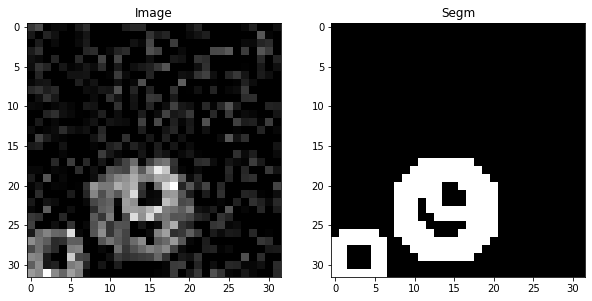

In [5]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(X_train[index, :, :, 0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_train[index, :, :, 0])
plt.title("Segm")

## Model definition

In the following, we define the architecture you will use for segmentation, namely a U-Network has been provided for you. Using the keras syntaxis train the model with the previously generated datasets.

In [11]:
nb_filters_0 = 8
sigma_noise = 0.01

iput_shape = (img_rows, img_cols, img_channels)
model = u_net(iput_shape, nb_filters_0, sigma_noise=sigma_noise, drop=0.3)

####################################
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=dice2_loss,
              metrics=[dice1_coef, jaccard1_coef])
model.summary()
####################################

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 32, 32, 8)    80          ['input_3[0][0]']                
                                                                                                  
 conv1_2 (Conv2D)               (None, 32, 32, 8)    584         ['conv1_1[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 8)   0           ['conv1_2[0][0]']                
                                                                                            

In [7]:
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/10


2023-01-03 20:14:08.099742: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - 11s 129ms/step - loss: 0.3880 - dice1_coef: 0.4616 - jaccard1_coef: 0.3188 - val_loss: 0.1336 - val_dice1_coef: 0.7641 - val_jaccard1_coef: 0.6183
Epoch 2/10
79/79 [==============================] - 10s 131ms/step - loss: 0.1392 - dice1_coef: 0.7573 - jaccard1_coef: 0.6101 - val_loss: 0.0961 - val_dice1_coef: 0.8417 - val_jaccard1_coef: 0.7267
Epoch 3/10
79/79 [==============================] - 10s 131ms/step - loss: 0.1140 - dice1_coef: 0.8054 - jaccard1_coef: 0.6744 - val_loss: 0.0902 - val_dice1_coef: 0.8559 - val_jaccard1_coef: 0.7482
Epoch 4/10
79/79 [==============================] - 11s 141ms/step - loss: 0.1066 - dice1_coef: 0.8193 - jaccard1_coef: 0.6941 - val_loss: 0.0861 - val_dice1_coef: 0.8603 - val_jaccard1_coef: 0.7549
Epoch 5/10
79/79 [==============================] - 12s 147ms/step - loss: 0.1018 - dice1_coef: 0.8279 - jaccard1_coef: 0.7065 - val_loss: 0.0820 - val_dice1_coef: 0.8660 - val_jaccard1_coef: 0.7637
Epoch 6/10
79/79

# TESTS

## Test

Once the model has been trained, you can evaluate its performance on the test set generated below.

16/16 [==============================] - 0s 13ms/step
[0.0799856185913086, 0.8788045644760132, 0.7842183113098145]


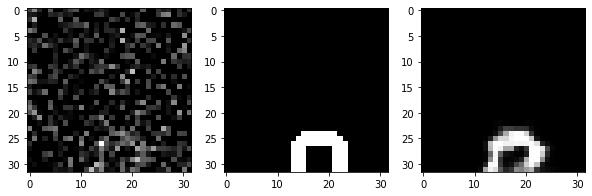

In [8]:

(X_test, Y_test) = next(datagen.flow(batch_size=512))
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
plt.subplot(1, 3, 1)
plt.imshow(X_test[0,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[0,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[0,:,:,0])

# Rings hidden by disks

The images you will need to segment now present a more challenging problem. The rings un the image be occluded by random disks. 

Use a scheme similar to the one proposed above to solve this problem.

## Data generation

The following cell generates the datasets you will use in this part of the assignment.

In [ ]:
img_rows, img_cols = 32, 32
img_channels = 1
gauss_n_std = 40
nb_obj_l = 1
nb_obj_h = 4
r1_disk_l = 2
r1_disk_h = 4
r1_ring_l = 4
r1_ring_h = 8
grey_l = 20
grey_h = 200
norm = 255  

l_rog = [
    ROG_rings(
        RandomIntGenUniform(nb_obj_l, nb_obj_h),
        RandomPosGenUniform(img_rows, img_cols),
        RandomIntGenUniform(r1_ring_l, r1_ring_h),
        RandomIntGenUniform(grey_l, grey_h),
        gt=1,
        rad_ratio=0.5),
    ROG_disks(
        RandomIntGenUniform(3 * nb_obj_l, 3 * nb_obj_h),
        RandomPosGenUniform(img_rows, img_cols),
        RandomIntGenUniform(r1_ring_l, r1_ring_h),
        RandomIntGenUniform(grey_l, grey_h),
        gt=0),
]

noise = AdditiveGaussianNoise(gauss_n_std)
datagen = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,
    noise,
    background_val=0,
    shuffle=False,
    norm=norm)
datagen_val = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,
    noise,
    background_val=0,
    shuffle=False,
    norm=norm)

In [ ]:
(X_train, Y_train) = next(datagen.flow(batch_size=nb_train_samples))
(X_val0, Y_val0) = next(datagen_val.flow(batch_size=nb_val_samples))

In [ ]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(X_train[index, :, :, 0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_train[index, :, :, 0])
plt.title("Segm")

In [ ]:
nb_filters_0 = 16
sigma_noise = 0.05

iput_shape = (img_rows, img_cols, img_channels)
model = u_net3(iput_shape, nb_filters_0, sigma_noise=sigma_noise, conv_size=3)

####################################
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice2_loss,
              metrics=[dice1_coef])
model.summary()
####################################

In [ ]:
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val0, Y_val0),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

In [ ]:
(X_test, Y_test) = next(datagen.flow(batch_size=1))
Y_pred = model.predict(X_test)

plt.subplot(1, 3, 1)
plt.imshow(X_test[0,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[0,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[0,:,:,0])

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 1))
res_model = UNet(8, 3, (32, 32, 1), resnet=True, mtype=['simple'])(inputs)
res_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=dice1_loss,
                 metrics=[dice1_coef])

res_model.fit(X_train, Y_train, batch_size=512, epochs=30, validation_data=(X_val0, Y_val0))


In [ ]:
(X_test, Y_test) = next(datagen.flow(batch_size=1))
Y_pred = res_model.predict(X_test)

plt.subplot(1, 3, 1)
plt.imshow(X_test[0,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[0,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[0,:,:,0])